In [261]:
import numpy as np
from numpy.linalg import svd, norm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from from_github import *


url = "https://www.stlouisfed.org/-/media/project/frbstl/stlouisfed/research/fred-md/monthly/current.csv?sc_lang=en&hash=80445D12401C59CF716410F3F7863B64"

df = pd.read_csv(url)

In [262]:
# Define transformation functions according to FRED-MD specifications
def identity(x: pd.Series) -> pd.Series:
    return x

def lag1(x: pd.Series) -> pd.Series:
    return x.shift(1)

def diff(x: pd.Series) -> pd.Series:
    return x.diff()

def diff2(x: pd.Series) -> pd.Series:
    return x.diff().diff()

def logdiff(x: pd.Series) -> pd.Series:
    return np.log(x) - np.log(x.shift(1))

def logdiff2(x: pd.Series) -> pd.Series:
    return (np.log(x) - np.log(x.shift(1))).diff()

def diffp(x: pd.Series) -> pd.Series:
    return ((x / x.shift(1)) - 1).diff()

def logd(x: pd.Series) -> pd.Series:
    return np.log(x)

# Create a tuple of transformation functions indexed by tcode
tfuns = [identity, diff, diff2, logd, logdiff, logdiff2, diffp]

In [263]:
def df_cleaning(df):
    df_onlydata = df.iloc[1:-1].copy()
    df_onlydata['sasdate'] = pd.to_datetime(df_onlydata['sasdate'], format='%m/%d/%Y')
    df_onlydata = df_onlydata[
        (df_onlydata['sasdate'] >= pd.Timestamp(1960, 1, 1)) &
        (df_onlydata['sasdate'] <= pd.Timestamp(2025, 3, 1))
    ]

    # Extract transformation codes and convert to int - 1
    tcode = df.iloc[0, 1:].astype(float) - 1  # exclude 'sasdate' column

    for i, col in enumerate(df_onlydata.columns[1:]):  # skip 'sasdate'
        trcode = int(tcode.iloc[i])
        if 0 <= trcode < len(tfuns):
            df_onlydata[col] = tfuns[trcode](df_onlydata[col])
        else:
            raise ValueError(f"Invalid transformation code {trcode} for column {col}")

    return df_onlydata.reset_index(drop=True), tcode


fredmd, tcode = df_cleaning(df)

In [264]:
def mark_outliers_as_missing(df:pd.DataFrame, k:int = 10.0):
    for col in df.columns.drop('sasdate'):
        x = df[col]
        xclean = x.dropna()
        q25, median, q75 = xclean.quantile([0.25, 0.5, 0.75])
        iqr = q75 - q25
        threshold = k * iqr
        mask = (x - median).abs() >= threshold
        df.loc[mask, col] = np.nan
    return df

fredmd_nooutliers = mark_outliers_as_missing(fredmd)

In [265]:
def pca_em_missing(df: pd.DataFrame, r: int, max_iter: int = 1000, tol: float = 1e-6):
    """
    PCA with EM algorithm to handle missing values (Stock and Watson, 2002).

    Parameters:
        df: pandas DataFrame with a 'sasdate' column and other numeric columns (some may have NaNs).
        r: number of static factors.
        max_iter: max number of EM iterations.
        tol: convergence tolerance for factors.

    Returns:
        F: T x r matrix of estimated factors
        Lambda: N x r matrix of loadings
        X_completed: T x N DataFrame with imputed values and original 'sasdate'
    """
    # Separate date and data columns
    date_col = df['sasdate'].reset_index(drop=True)
    X_raw = df.drop(columns=['sasdate']).to_numpy()
    T, N = X_raw.shape
    mask = ~np.isnan(X_raw)

    # Initial mean and std ignoring NaNs
    mu = np.nanmean(X_raw, axis=0)
    sigma = np.nanstd(X_raw, axis=0)

    # Handle constant columns to avoid division by zero
    sigma[sigma == 0] = 1.0

    # Standardize and initialize missing with zero
    X_std = (X_raw - mu) / sigma
    X_std[np.isnan(X_std)] = 0

    for iteration in range(max_iter):
        try:
            # Ensure finite values before SVD
            X_std = np.nan_to_num(X_std, nan=0.0, posinf=0.0, neginf=0.0)
            U, S, Vt = svd(X_std, full_matrices=False)
        except LinAlgError as e:
            raise RuntimeError("SVD did not converge. Check for ill-conditioned data or increase preprocessing.") from e

        F_new = U[:, :r] * S[:r]  # T x r
        Lambda = Vt[:r, :].T      # N x r

        # Normalize Lambda: Lambda^T Lambda / N = I_r
        Lambda /= np.sqrt(np.sum(Lambda ** 2, axis=0) / N)

        # Check convergence
        if iteration > 0 and norm(F_new - F_old) < tol:
            break

        # Update missing values
        X_hat = F_new @ Lambda.T  # T x N
        X_hat = X_hat * sigma + mu

        X_completed = X_raw.copy()
        X_completed[~mask] = X_hat[~mask]

        # Recompute mean and std
        mu = np.mean(X_completed, axis=0)
        sigma = np.std(X_completed, axis=0)
        sigma[sigma == 0] = 1.0

        X_std = (X_completed - mu) / sigma
        F_old = F_new

    # Return completed DataFrame with 'sasdate'
    completed_df = pd.DataFrame(X_completed, columns=df.columns.drop('sasdate'))
    completed_df.insert(0, 'sasdate', date_col)
    completed_df.fillna(0,inplace=True)

    return F_new, Lambda, completed_df


In [266]:
F, Lambda, completed_df = pca_em_missing(fredmd_nooutliers, 8)

/opt/anaconda3/envs/datasc/lib/python3.13/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/var/folders/5t/955sw5x10db2z7_m7d1x7hkh0000gn/T/ipykernel_87206/393026225.py:53: RuntimeWarning: invalid value encountered in multiply
  X_hat = X_hat * sigma + mu
/opt/anaconda3/envs/datasc/lib/python3.13/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/var/folders/5t/955sw5x10db2z7_m7d1x7hkh0000gn/T/ipykernel_87206/393026225.py:63: RuntimeWarning: invalid value encountered in subtract
  X_std = (X_completed - mu) / sigma
/opt/anaconda3/envs/datasc/lib/python3.13/site-packages/numpy/_core/_methods.py:135: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/opt/anaconda3/envs/datasc/lib/python3.13/site-packages/numpy/_core/_methods.py:171: RuntimeWarning: invalid value encountered 

In [267]:
completed_df.isna().sum().sum()

np.int64(0)

In [268]:
import matplotlib.pyplot as plt

def plot_factors(F: np.ndarray, dates: pd.Series):
    """
    Plot estimated factors over time.

    Parameters:
        F: T x r matrix of estimated factors
        dates: pd.Series of datetime values (e.g., from 'sasdate' column)
    """
    r = F.shape[1]
    plt.figure(figsize=(12, r * 2.5))
    for i in range(r):
        plt.subplot(r, 1, i + 1)
        plt.plot(dates, F[:, i])
        plt.title(f'Factor {i + 1}')
        plt.tight_layout()
    plt.show()


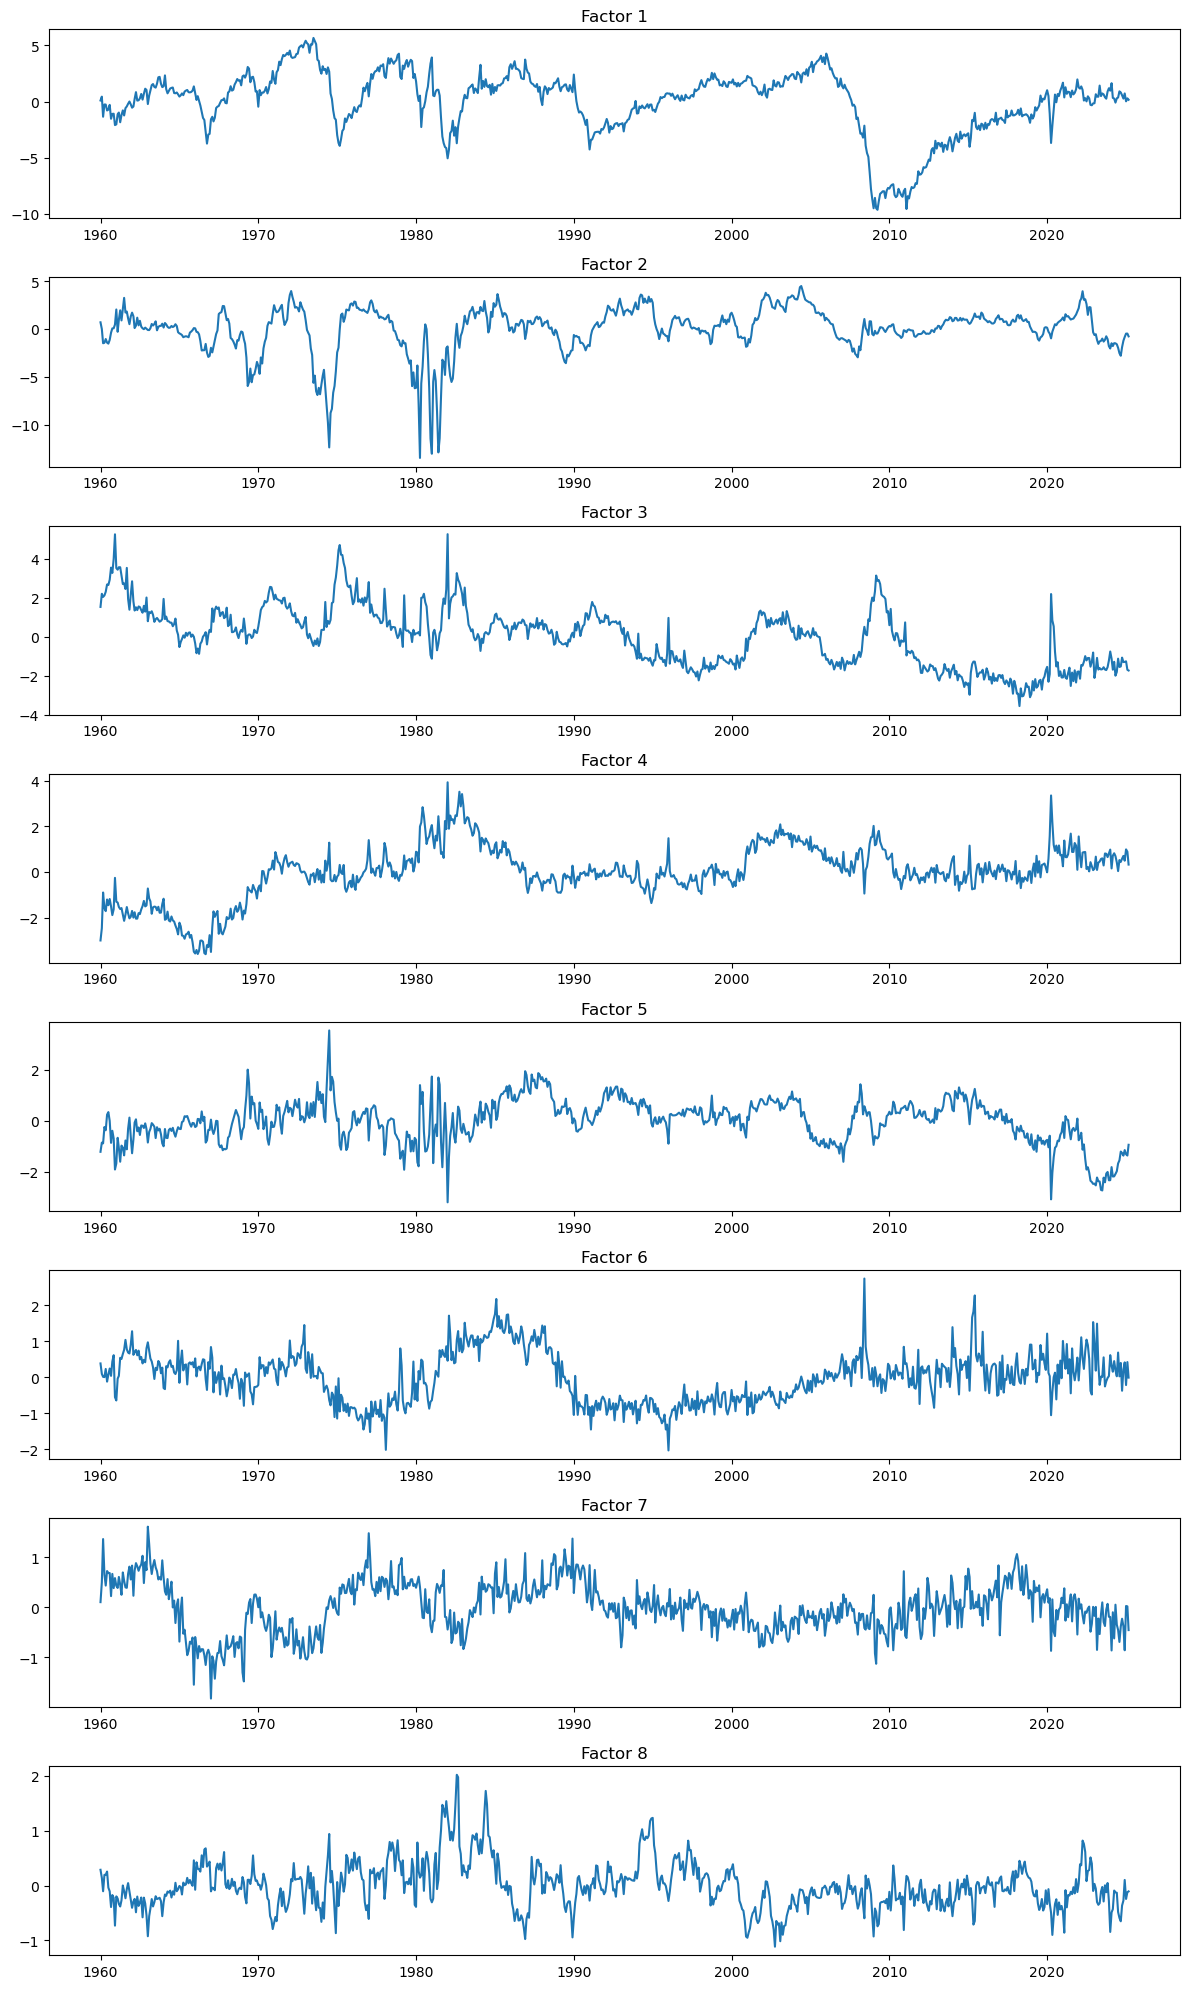

In [269]:
dates = completed_df['sasdate']
plot_factors(F, dates)

In [270]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def factor_r2_table(F: np.ndarray, X: np.ndarray, column_names: list, top_n: int = 10) -> pd.DataFrame:
    """
    Create R² table showing top_n series by R² for each factor.

    Parameters:
        F: T x r matrix of factors
        X: T x N matrix of completed data (numeric only, no 'sasdate')
        column_names: list of series names (column headers)
        top_n: number of top series to show per factor

    Returns:
        pd.DataFrame: R² values for top_n series per factor
    """
    T, r = F.shape
    N = X.shape[1]
    R2_table = {}

    for k in range(r):
        r2_scores = []
        for i in range(N):
            model = LinearRegression().fit(F[:, [k]], X[:, i])
            r2 = model.score(F[:, [k]], X[:, i])
            r2_scores.append((column_names[i], r2))
        
        # Sort and take top_n
        top = sorted(r2_scores, key=lambda x: -x[1])[:top_n]
        R2_table[f'Factor {k+1}'] = [f'{var} ({r2:.3f})' for var, r2 in top]

    return pd.DataFrame(R2_table)

# Example usage:
# completed_df: from pca_em_missing
# F: factors from pca_em_missing
X = completed_df.drop(columns=['sasdate']).to_numpy()
cols = completed_df.columns.drop('sasdate')
table_df = factor_r2_table(F, X, cols, top_n=10)
print(table_df)


           Factor 1           Factor 2               Factor 3  \
0     HOUST (0.928)     T5YFFM (0.803)  CES0600000007 (0.818)   
1    PERMIT (0.818)     T1YFFM (0.776)         AWHMAN (0.783)   
2    HOUSTW (0.791)   TB6SMFFM (0.753)        PERMITS (0.217)   
3   PERMITW (0.784)    T10YFFM (0.744)         USGOOD (0.111)   
4    HOUSTS (0.723)   TB3SMFFM (0.673)        HOUSTNE (0.110)   
5  PERMITMW (0.693)     AAAFFM (0.647)         MANEMP (0.081)   
6   HOUSTMW (0.645)     BAAFFM (0.532)        DMANEMP (0.079)   
7  PERMITNE (0.628)  COMPAPFFx (0.339)       UEMP15OV (0.068)   
8   HOUSTNE (0.545)     PERMIT (0.101)        HOUSTMW (0.066)   
9   PERMITS (0.388)    PERMITW (0.085)         PAYEMS (0.062)   

                Factor 4           Factor 5               Factor 6  \
0        PERMITS (0.259)   TB3SMFFM (0.136)        HOUSTMW (0.125)   
1      COMPAPFFx (0.197)   TB6SMFFM (0.114)        HOUSTNE (0.115)   
2        VIXCLSx (0.155)  COMPAPFFx (0.095)       PERMITNE (0.107)   
3   

# Forecast

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from itertools import product
from sklearn.metrics import mean_squared_error


def create_lagged_matrix(series, max_lag):
    return pd.concat([series.shift(lag) for lag in range(1, max_lag + 1)], axis=1)


def prepare_design_matrix(y, factors, h, ar_lags, factor_lags):
    y_lags = create_lagged_matrix(y, ar_lags)
    f1_lags = create_lagged_matrix(factors.iloc[:, 0], factor_lags)

    # Trim to align with forecast horizon h
    max_lag = max(ar_lags, factor_lags) if max(ar_lags, factor_lags) > 0 else 1
    X = pd.concat([y_lags, f1_lags], axis=1).dropna()
    X = add_constant(X)
    y_target = y.shift(-h).loc[X.index]

    return X, y_target


def bic_ols(X, y):
    model = OLS(y, X).fit()
    n = len(y)
    k = X.shape[1]
    bic = model.bic
    return model, bic


def select_model_by_bic(y, factors, h):
    best_bic = np.inf
    best_model = None
    best_config = None

    for p, q in product(range(0, 7), [1, 2, 3]):
        try:
            X, y_target = prepare_design_matrix(y, factors, h, p, q)
            model, bic = bic_ols(X, y_target)
            if bic < best_bic:
                best_bic = bic
                best_model = model
                best_config = {'AR_lags': p, 'Factor_lags': q}
        except Exception:
            continue

    return best_model, best_config


def forecast_indpro(y, factors, h):
    model, config = select_model_by_bic(y, factors, h)
    last_y_lags = y.iloc[-config['AR_lags']:][::-1].values if config['AR_lags'] > 0 else np.array([])
    last_f1_lags = factors.iloc[-config['Factor_lags']:, 0][::-1].values

    X_new = np.concatenate([last_y_lags, last_f1_lags])
    X_new = np.insert(X_new, 0, 1.0)  # constant
    y_forecast = np.dot(X_new, model.params)

    return y_forecast, config, model

indpro_series = completed_df['INDPRO']
pca_factors = F

# Example usage (assumes you have 'indpro_series' and 'pca_factors' DataFrames ready):
forecast, config, model = forecast_indpro(indpro_series, pca_factors, h=1)
print("Forecast:", forecast)
print("Selected config:", config)
print(model.summary())



TypeError: 'NoneType' object is not subscriptable